reference:
> Feature Mode Decomposition: New Decomposition Theory for Rotating Machinery
 Fault Diagnosis

Flow diagram of FMD  

1. load raw signal ```x```, Iput decomposed mode number ```n```, filter length ```L```

2. Initialize FIR filter band with ```K``` filters and start iteration ```i=1```

3. Obtain filtered signal or decomposed mode  $u_k^i$   ```Node 3```

4. Period Estimation 
    + compute autocorrelation $R_k^i$ of decomposed mode $u_k^i$
    + find the local maximum value of $R_k^i$ to get estimated periode $T_k^i$



In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, correlate, find_peaks,hilbert
import pandas as pd

In [40]:
FilterSize = 30 # filter length L
CutNum = 7 #the cut number of the whole frequency band
ModeNum = 2 #the final mode number
MaxIterNum = 20 # max iteration number
fs = 2e4 #sampling frequency of x
signal_x = np.array(pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK").iloc[:,1])



In [53]:
class FMD_reconsitution():

    def __init__(self, FilterSize, CutNum,ModeNum,MaxIterNum,fs=None):
        
        self.FilterSize = FilterSize
        self.CutNum= CutNum
        self.ModeNum = ModeNum
        self.MaxIterNum =MaxIterNum
        self.fs = 2e4 if fs ==None else fs

    def initialize_filters(self,L, K):
        
        filters = []
        K = self.CutNum
        eps = np.finfo(float).eps
        freq_bound = np.arange(0, 1, 1 / K)
        L= self.FilterSize
        filters = [
            firwin(FilterSize, [freq_bound[n] + eps, freq_bound[n] + 1 / CutNum - eps],w="hann")
            for n in range(len(freq_bound))
        ]
        
        return filters
    
    def result_initialization(self):
        
        result = pd.DataFrame(
            [[None] * 5 for _ in range(self.CutNum + 1)],
            columns=['IterCount', 'Iterations', 'CorrMatrix', 'ComparedModeNum', 'StopNum']
        )
        
        return result
    
    def update_FIR(self,signal,filters):

        updated_filters = []
        for f in filters:
            period = self.estimate_period(np.convolve(signal, f, mode='same'))
            low_cutoff = max(0, 1 / period - 0.1)
            high_cutoff = min(0.5, 1 / period + 0.1)
            updated_filters.append(firwin(len(f), [low_cutoff, high_cutoff], pass_zero=False, window='hann'))
        
        return updated_filters
   
    def T_estimated(self,signal_x):

        u = np.abs(hilbert(signal_x)) - np.mean(np.abs(hilbert(signal_x)))
        
        return np.argmax(np.correlate(u,u,"full")[int(len(u)//2):])
        # return np.correlate(u,u,"full")[int(len(u)//2):]


    def CK(self,x = None,T = None,M = 2): 

        x = x.flatten()
        N = len(x)

        x_shift = np.zeros((M + 1,N))
        x_shift[0,:] = x

        for m in range(M):
            if T < N: x_shift[m + 1,T+1:] = x_shift[m,:-T-1]
        
        numerator = np.sum(np.prod(x_shift, axis=0)**2)
        denominator = np.sum(x**2)**(M + 1)
        ck = numerator / denominator
        return ck

    def estimate_period(self,x):
        
        signal = x
        correlation = correlate(signal, signal, mode='full')
        correlation = correlation[len(correlation) // 2:]
        peaks, _ = find_peaks(correlation)
        if len(peaks) > 1:
            period = peaks[1]
        else:
            period = len(signal)
        
        return period
    
    def decompose_modes(x, filters):
        modes = []
        for filt in filters:
            # 对信号x应用每个滤波器
            mode = lfilter(filt, [1.0], x)
            modes.append(mode)
        return modes

    def processing(self,signal_x):
        x = signal_x
        if self.FilterSize % 2 == 0:self.FilterSize += 1  
        temp_filters = self.initialize_filters()
        result = self.result_initialization()

        Final_Mode = None
        return Final_Mode

In [54]:
fmd = FMD_reconsitution(
    FilterSize=FilterSize,
    CutNum=CutNum,
    ModeNum=ModeNum,
    fs=None,
    MaxIterNum =MaxIterNum
)

In [43]:
all(x<y for x,y in zip([i for i in range(5)],[i for i in range(1,6)]))

True

# maximum correlated kurtosis deconvolution(mckd)

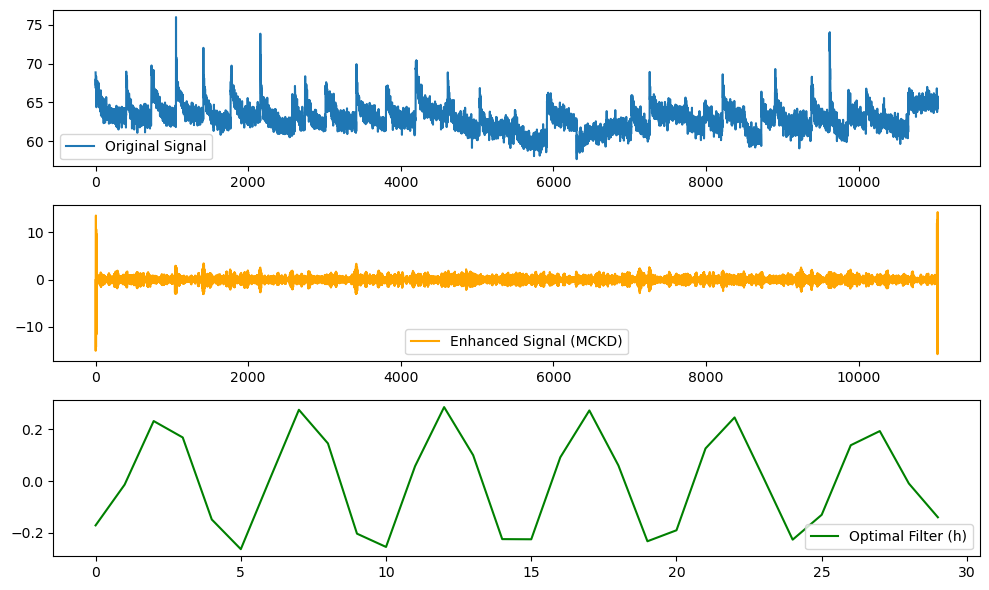

In [44]:
import numpy as np
from scipy.linalg import toeplitz

def mckd(signal, filter_length, delay, iterations=50):
    """
    Perform Maximum Correlated Kurtosis Deconvolution (MCKD).

    Parameters:
        signal (numpy array): The input signal.
        filter_length (int): The length of the FIR filter.
        delay (int): The delay parameter (d).
        iterations (int): Number of iterations for optimization.

    Returns:
        enhanced_signal (numpy array): The deconvolved signal.
        optimal_filter (numpy array): The optimized filter.
    """
    n = len(signal)
    
    # Step 1: Initialize FIR filter
    h = np.zeros(filter_length)
    h[filter_length // 2] = 1  # Start with a simple filter (impulse)
    
    # Step 2: Iterative optimization
    for _ in range(iterations):
        # Construct Toeplitz matrix for current signal
        X = toeplitz(signal, np.zeros(filter_length))
        
        # Compute the deconvolved signal
        y = np.convolve(signal, h, mode='same')
        
        # Compute the delayed signal matrix
        Yd = toeplitz(y[delay:], np.zeros(filter_length))
        
        # Compute covariance matrices
        R0 = X.T @ X
        R1 = Yd.T @ Yd
        
        # Update filter by solving generalized eigenvalue problem
        _, eigvecs = np.linalg.eig(np.linalg.inv(R0) @ R1)
        h = eigvecs[:, 0]  # Use eigenvector corresponding to max eigenvalue
        h /= np.linalg.norm(h)  # Normalize filter
    
    # Step 3: Apply optimized filter to the signal
    enhanced_signal = np.convolve(signal, h, mode='same')
    
    return enhanced_signal, h

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Generate a test signal with impulses and noise
    np.random.seed(0)
    t = np.linspace(0, 1, 500)
    impulses = np.zeros_like(t)
    impulses[50] = 1
    impulses[200] = 1
    impulses[350] = 1
    noise = 0.5 * np.random.randn(len(t))
    signal = impulses + noise
    signal=signal_x

    # Perform MCKD
    enhanced_signal, optimal_filter = mckd(signal, filter_length=30, delay=10, iterations=50)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(signal, label="Original Signal")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(enhanced_signal, label="Enhanced Signal (MCKD)", color='orange')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(optimal_filter, label="Optimal Filter (h)", color='green')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


![图片](formula\Nomenclature.png)

![图片](formula/12.png)

In [ ]:
#(12)
y= np.array([])
beta =np.array([])
x0 = np.array([])
alpha0 = np.array([])
alpha1 = np.array([])
Xs = np.array([])

#范数计算
norm_y = np.linalg.norm(y, 2)**2
norm_beta = np.linalg.norm(beta, 2)**2

# 计算 (X0 * X0^T)^(-1)
X0_inv = np.linalg.inv(x0 @ x0.T)

# 计算滤波器 f
f = (norm_y / (2 * norm_beta)) * X0_inv @ (x0 @ alpha0 + Xs @ alpha1)



$$
\alpha _0 =[y_1 y^2_{1-T_s},y_2 y^2_{2-T_s}, ..., y_N y^2_{N-T_s}]^T  
$$
$$
\alpha _1 =[y_{1-T_s} y_1^2, y_{2-T_s} y_2^2, ...,  y_{N-T_s} y_N^2]^T
$$
$$
\beta = [y_{1-T_s} y_1, y_{2-T_s} y_2, ...,  y_{N-T_s} y_N]^T
$$

In [ ]:
y = np.array([1,2,3,4,5,6,8,9,10])
ts= 2
T = None
N = len(signal_x)
alpha0 = [y[n],y[n-ts]]

$$
y_n = \displaystyle\sum_{l=1}^L f_l x_{n+L-l}
$$

In [58]:
T = fmd.estimate_period(signal_x)

In [59]:
T

11040

In [ ]:
x = signal_x
L = 30
M =3
N = len(x)
XmT = np.zeros((L, N, M+1))
# XmT[:,:,0]
# x_t =np.zeros((L,N))
# for i in range(L):
#     x_t[i,:]=np.concatenate(((np.zeros(i)),np.array(x[:N-i])))
XmT[:,:,0]=np.array([np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)])


In [120]:
XmT[:,:,0]

array([[68.87514 , 68.500084, 66.843834, ..., 64.68798 , 65.28982 ,
        64.31443 ],
       [ 0.      , 68.87514 , 68.500084, ..., 64.31443 , 64.68798 ,
        65.28982 ],
       [ 0.      ,  0.      , 68.87514 , ..., 65.18828 , 64.31443 ,
        64.68798 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 65.84421 , 65.50179 ,
        64.47008 ],
       [ 0.      ,  0.      ,  0.      , ..., 65.87534 , 65.84421 ,
        65.50179 ],
       [ 0.      ,  0.      ,  0.      , ..., 64.750244, 65.87534 ,
        65.84421 ]])

In [115]:
np.zeros(0)

array([], dtype=float64)

In [106]:
x=[x[:i][::-1] for i in range(1,L+1)]

In [63]:
XmT

array([[[68.87514 ,  0.      ,  0.      ,  0.      ],
        [68.500084,  0.      ,  0.      ,  0.      ],
        [66.843834,  0.      ,  0.      ,  0.      ],
        ...,
        [64.68798 ,  0.      ,  0.      ,  0.      ],
        [65.28982 ,  0.      ,  0.      ,  0.      ],
        [64.31443 ,  0.      ,  0.      ,  0.      ]],

       [[ 0.      ,  0.      ,  0.      ,  0.      ],
        [68.87514 ,  0.      ,  0.      ,  0.      ],
        [68.500084,  0.      ,  0.      ,  0.      ],
        ...,
        [64.31443 ,  0.      ,  0.      ,  0.      ],
        [64.68798 ,  0.      ,  0.      ,  0.      ],
        [65.28982 ,  0.      ,  0.      ,  0.      ]],

       [[ 0.      ,  0.      ,  0.      ,  0.      ],
        [ 0.      ,  0.      ,  0.      ,  0.      ],
        [68.87514 ,  0.      ,  0.      ,  0.      ],
        ...,
        [65.18828 ,  0.      ,  0.      ,  0.      ],
        [64.31443 ,  0.      ,  0.      ,  0.      ],
        [64.68798 ,  0.      ,  0.     

In [64]:
x=[1,2,3,5,6,7]
x[::-1]

[7, 6, 5, 3, 2, 1]